In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

2024-07-08 16:16:22.084199: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 16:16:22.098695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 16:16:22.118373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 16:16:22.118403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 16:16:22.130869: I tensorflow/core/platform/cpu_feature_gua

## Load the Data

We will use the Numenta Anomaly Benchmark(NAB) dataset. It provides artificial timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.csv file for testing. The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

df_train = df_small_noise
df_test = df_daily_jumpsup

### Quick look at train data

In [3]:
df_train.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


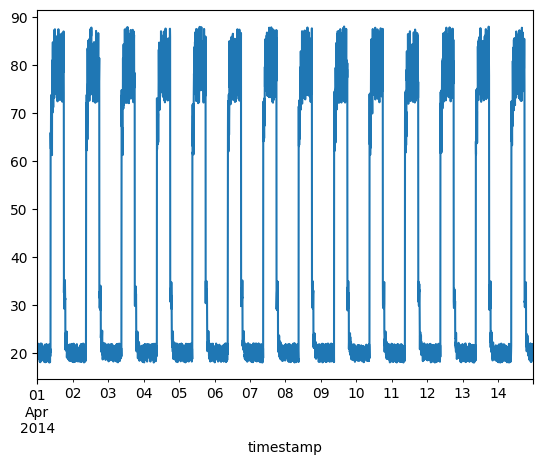

In [4]:
fig, ax = plt.subplots()
df_train.plot(legend=False, ax=ax)
plt.show()

### Quick look at test data

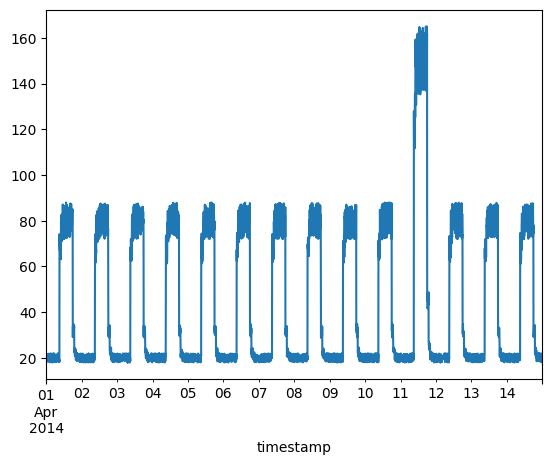

In [5]:
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
plt.show()

In [6]:
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std
df_test_value = (df_test - training_mean) / training_std

print(df_training_value)

                        value
timestamp                    
2014-04-01 00:00:00 -0.858829
2014-04-01 00:05:00 -0.728993
2014-04-01 00:10:00 -0.848148
2014-04-01 00:15:00 -0.729586
2014-04-01 00:20:00 -0.731173
...                       ...
2014-04-14 23:35:00 -0.791647
2014-04-14 23:40:00 -0.780255
2014-04-14 23:45:00 -0.833640
2014-04-14 23:50:00 -0.735102
2014-04-14 23:55:00 -0.846089

[4032 rows x 1 columns]


**Data Time Period**

## Data Preprocessing

#### 2. Data Scaling

In [7]:
# scaler = StandardScaler()
# scaler = scaler.fit(np.array(df_train['value']).reshape(-1,1))

# df_train['scaled_value'] = scaler.transform(np.array(df_train['value']).reshape(-1,1))
# df_test['scaled_value'] = scaler.transform(np.array(df_test['value']).reshape(-1,1))

In [8]:
df_train.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 2 as we want our network to have memory of last 2 days.

In [9]:
TIME_STEPS=288

def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

X_test = create_sequences(df_test_value.values)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3745, 288, 1)
Testing input shape:  (3745, 288, 1)


In [10]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [11]:
from keras import layers
model_convd = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Conv1DTranspose(filters=16,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32,kernel_size=7,padding="same",strides=2,activation="relu",),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model_convd.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model_convd.summary()

2024-07-08 16:16:26.967415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 849 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-07-08 16:16:26.969798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37960 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_convd = model_convd.fit(X_train,
                    X_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])

Epoch 1/50


I0000 00:00:1720435588.174006   45228 service.cc:145] XLA service 0x75c3900056a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720435588.174073   45228 service.cc:153]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
I0000 00:00:1720435588.174085   45228 service.cc:153]   StreamExecutor device (1): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-07-08 16:16:28.222430: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 16:16:28.428804: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-08 16:16:29.570265: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performan

14/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9421 

I0000 00:00:1720435591.827921   45228 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.8030

2024-07-08 16:16:35.532332: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.7937 - val_loss: 0.1065
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0929 - val_loss: 0.0405
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0601 - val_loss: 0.0350
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0502 - val_loss: 0.0308
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 - val_loss: 0.0270
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0393 - val_loss: 0.0259
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0356 - val_loss: 0.0238
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326 - val_loss: 0.0220
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - val_loss: 0.0203
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - val_loss: 0.0196
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0268 - val_loss: 0.0192
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0254 - val_loss: 0.018

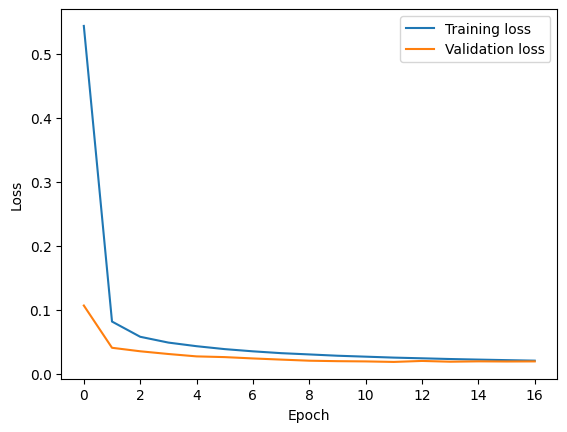

In [13]:
plt.plot(history_convd.history['loss'], label='Training loss')
plt.plot(history_convd.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [14]:
X_train_pred2 = model_convd.predict(X_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


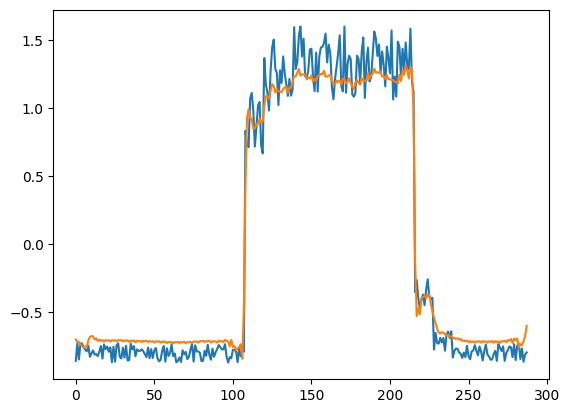

In [15]:
plt.plot(X_train[0])
plt.plot(X_train_pred2[0])
plt.show()

In [16]:
# Encoder 
encoder = Sequential()
encoder.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
encoder.add(LSTM(64, activation='tanh'))
encoder.add(Dropout(rate=0.1))
encoder.add(RepeatVector(X_train.shape[1]))
# Decoder 
decoder = Sequential()
decoder.add(LSTM(64, activation='tanh', return_sequences=True))
decoder.add(LSTM(256, activation='tanh', return_sequences=True))
decoder.add(Dropout(rate=0.1))
decoder.add(TimeDistributed(Dense(X_train.shape[2])))

# Autoencoder
model = Sequential([encoder, decoder])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

/home/giri/anaconda3/envs/gpu/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Train Model

In [17]:
history = model.fit(X_train,
                    X_train,
                    epochs=50,
                    batch_size=2,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')])

Epoch 1/50


1685/1685 ━━━━━━━━━━━━━━━━━━━━ 130s 71ms/step - loss: 0.9774 - val_loss: 0.9337
Epoch 2/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 114s 68ms/step - loss: 0.9020 - val_loss: 1.0116
Epoch 3/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 104s 62ms/step - loss: 0.9995 - val_loss: 1.0101
Epoch 4/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 118s 70ms/step - loss: 0.9992 - val_loss: 1.0110
Epoch 5/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 116s 69ms/step - loss: 0.9992 - val_loss: 0.9732
Epoch 6/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - loss: 0.8838 - val_loss: 0.6677
Epoch 7/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 108s 64ms/step - loss: 0.7794 - val_loss: 0.3690
Epoch 8/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 112s 66ms/step - loss: 0.7789 - val_loss: 0.1781
Epoch 9/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 117s 69ms/step - loss: 0.2834 - val_loss: 0.1116
Epoch 10/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 115s 68ms/step - loss: 0.1697 - val_loss: 0.1096
Epoch 11/50
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 114s 68ms/step - loss: 0.1461 - val_loss: 0.1570
Epoch 12/

#### Plot Training - Validation loss

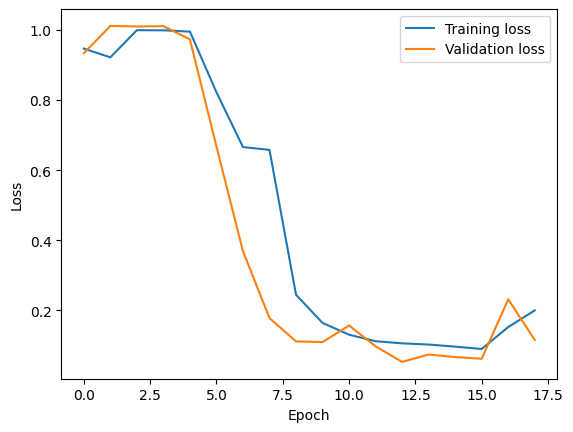

In [18]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [19]:
X_train_pred = model.predict(X_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step


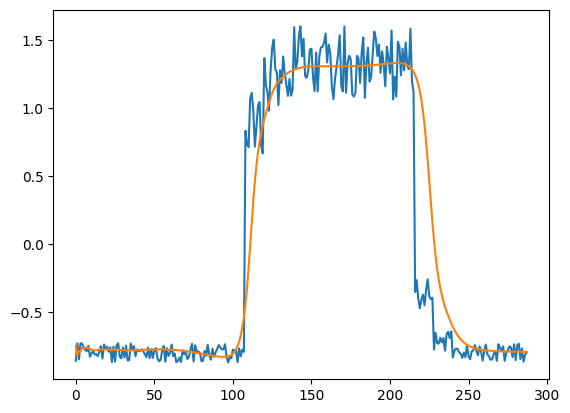

In [20]:
plt.plot(X_train[0])
plt.plot(X_train_pred[0])
plt.show()

Reconstruction error threshold: 0.2407255671609521


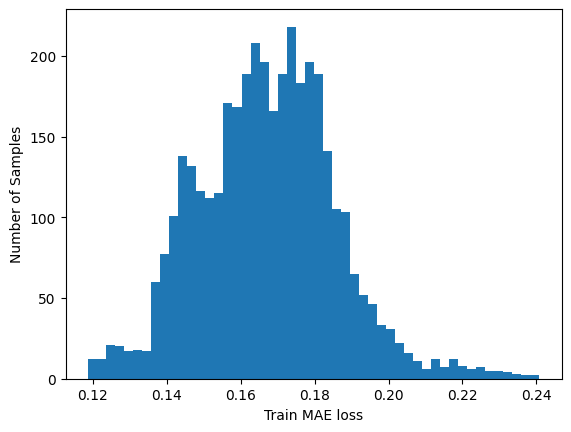

In [21]:
# Mean Absolute Error loss
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
#threshold = threshold + 0.10*threshold

print('Reconstruction error threshold:',threshold)

## Predict Anomalies on test data using threshold

  1/118 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step

118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


Text(0, 0.5, 'Number of samples')

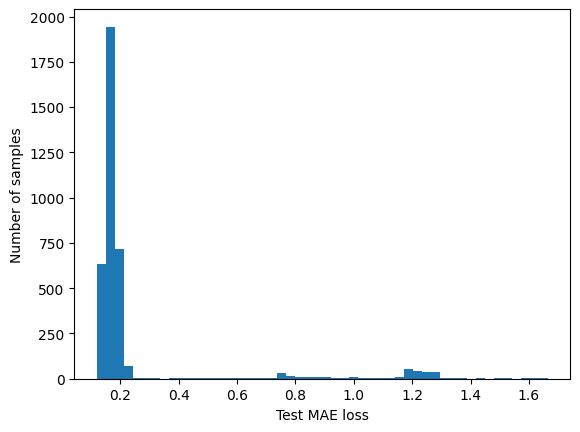

In [22]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [23]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  383
Indices of anomaly samples:  (array([1944, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844,
       2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2

In [24]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

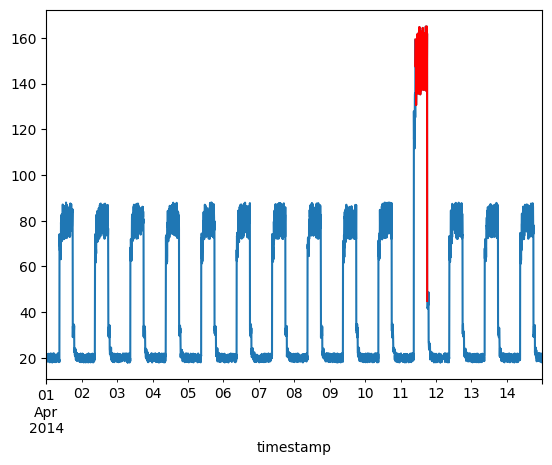

In [25]:
df_subset = df_test.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()